In [24]:
from langgraph.graph import StateGraph, END, START
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
import operator

In [16]:
load_dotenv()
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [17]:
class EvaluationSchema(BaseModel):

    feedback: str = Field(description="Detailed feedback for the essay")
    score:int = Field(description="Give a feedback score 1 to 10",ge=0,lt=11)

In [18]:
structured_model = llm.with_structured_output(EvaluationSchema)

In [19]:
essay = """India in the Age of AI
As the world enters a transformative era defined by artificial intelligence (AI), India stands at a critical juncture — one where it can either emerge as a global leader in AI innovation or risk falling behind in the technology race. The age of AI brings with it immense promise as well as unprecedented challenges, and how India navigates this landscape will shape its socio-economic and geopolitical future.

India's strengths in the AI domain are rooted in its vast pool of skilled engineers, a thriving IT industry, and a growing startup ecosystem. With over 5 million STEM graduates annually and a burgeoning base of AI researchers, India possesses the intellectual capital required to build cutting-edge AI systems. Institutions like IITs, IIITs, and IISc have begun fostering AI research, while private players such as TCS, Infosys, and Wipro are integrating AI into their global services. In 2020, the government launched the National AI Strategy (AI for All) with a focus on inclusive growth, aiming to leverage AI in healthcare, agriculture, education, and smart mobility.

One of the most promising applications of AI in India lies in agriculture, where predictive analytics can guide farmers on optimal sowing times, weather forecasts, and pest control. In healthcare, AI-powered diagnostics can help address India’s doctor-patient ratio crisis, particularly in rural areas. Educational platforms are increasingly using AI to personalize learning paths, while smart governance tools are helping improve public service delivery and fraud detection.

However, the path to AI-led growth is riddled with challenges. Chief among them is the digital divide. While metropolitan cities may embrace AI-driven solutions, rural India continues to struggle with basic internet access and digital literacy. The risk of job displacement due to automation also looms large, especially for low-skilled workers. Without effective skilling and re-skilling programs, AI could exacerbate existing socio-economic inequalities.

Another pressing concern is data privacy and ethics. As AI systems rely heavily on vast datasets, ensuring that personal data is used transparently and responsibly becomes vital. India is still shaping its data protection laws, and in the absence of a strong regulatory framework, AI systems may risk misuse or bias.

To harness AI responsibly, India must adopt a multi-stakeholder approach involving the government, academia, industry, and civil society. Policies should promote open datasets, encourage responsible innovation, and ensure ethical AI practices. There is also a need for international collaboration, particularly with countries leading in AI research, to gain strategic advantage and ensure interoperability in global systems.

India’s demographic dividend, when paired with responsible AI adoption, can unlock massive economic growth, improve governance, and uplift marginalized communities. But this vision will only materialize if AI is seen not merely as a tool for automation, but as an enabler of human-centered development.

In conclusion, India in the age of AI is a story in the making — one of opportunity, responsibility, and transformation. The decisions we make today will not just determine India’s AI trajectory, but also its future as an inclusive, equitable, and innovation-driven society."""


In [20]:
prompt = f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {essay}'
structured_model.invoke(prompt).feedback

"The essay provides a good overview of India's position in the age of AI, covering both opportunities and challenges. The language is clear and well-structured, making it easy to follow the main points. However, there's room for improvement in terms of depth and specific examples. The essay could benefit from more concrete data points and case studies to support its claims. Additionally, while the writing is generally strong, varying the sentence structure and using more vivid language could enhance its impact."

In [21]:
structured_model.invoke(prompt).score

8

In [45]:
class UPSCState(TypedDict):

    essay: str
    analysis_feedback: str
    language: str
    clarity_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int],operator.add]
    avg_score: float

In [46]:
def evaluate_lang(state:UPSCState):
    prompt = f"Evalute the essay: {state["essay"]} on the basis of language and give score 1 to 10"
    output = structured_model.invoke(prompt)

    return {"language":output.feedback,"individual_scores":[output.score]}

In [47]:
def evaluate_analysis(state:UPSCState):
    prompt = f"Evalute the essay: {state["essay"]} on the basis of depth of analysis and give score 1 to 10"
    output = structured_model.invoke(prompt)

    return {"analysis_feedback":output.feedback,"individual_scores":[output.score]}

In [48]:
def evaluate_clarity(state:UPSCState):
    prompt = f"Evalute the essay: {state["essay"]} on the basis of clarity of depth and give score 1 to 10"
    output = structured_model.invoke(prompt)

    return {"clarity_feedback":output.feedback,"individual_scores":[output.score]}

In [49]:
def final_evaluate(state: UPSCState):

    prompt = f'Based on the following feedbacks create a summarized feedback \n language feedback - {state["language"]} \n depth of analysis feedback - {state["analysis_feedback"]} \n clarity of thought feedback - {state["clarity_feedback"]}'
    overall_feedback = llm.invoke(prompt).content

    avg_score = sum(state['individual_scores'])/len(state['individual_scores'])

    return {'overall_feedback': overall_feedback, 'avg_score': avg_score}

In [50]:
graph = StateGraph(UPSCState)

graph.add_node("evaluate_lang",evaluate_lang)
graph.add_node("evaluate_analysis",evaluate_analysis)
graph.add_node("evaluate_clarity",evaluate_clarity)
graph.add_node("final_evaluate",final_evaluate)

graph.add_edge(START,"evaluate_lang")
graph.add_edge(START,"evaluate_analysis")
graph.add_edge(START,"evaluate_clarity")


graph.add_edge("evaluate_lang","final_evaluate")
graph.add_edge("evaluate_analysis","final_evaluate")
graph.add_edge("evaluate_clarity","final_evaluate")
graph.add_edge("final_evaluate",END)

workflow=graph.compile()



In [51]:
essay2 = """India and AI Time

Now world change very fast because new tech call Artificial Intel… something (AI). India also want become big in this AI thing. If work hard, India can go top. But if no careful, India go back.

India have many good. We have smart student, many engine-ear, and good IT peoples. Big company like TCS, Infosys, Wipro already use AI. Government also do program “AI for All”. It want AI in farm, doctor place, school and transport.

In farm, AI help farmer know when to put seed, when rain come, how stop bug. In health, AI help doctor see sick early. In school, AI help student learn good. Government office use AI to find bad people and work fast.

But problem come also. First is many villager no have phone or internet. So AI not help them. Second, many people lose job because AI and machine do work. Poor people get more bad.

One more big problem is privacy. AI need big big data. Who take care? India still make data rule. If no strong rule, AI do bad.

India must all people together – govern, school, company and normal people. We teach AI and make sure AI not bad. Also talk to other country and learn from them.

If India use AI good way, we become strong, help poor and make better life. But if only rich use AI, and poor no get, then big bad thing happen.

So, in short, AI time in India have many hope and many danger. We must go right road. AI must help all people, not only some. Then India grow big and world say "good job India"."""


In [52]:
intial_state = {
    'essay': essay2
}

workflow.invoke(intial_state)

{'essay': 'India and AI Time\n\nNow world change very fast because new tech call Artificial Intel… something (AI). India also want become big in this AI thing. If work hard, India can go top. But if no careful, India go back.\n\nIndia have many good. We have smart student, many engine-ear, and good IT peoples. Big company like TCS, Infosys, Wipro already use AI. Government also do program “AI for All”. It want AI in farm, doctor place, school and transport.\n\nIn farm, AI help farmer know when to put seed, when rain come, how stop bug. In health, AI help doctor see sick early. In school, AI help student learn good. Government office use AI to find bad people and work fast.\n\nBut problem come also. First is many villager no have phone or internet. So AI not help them. Second, many people lose job because AI and machine do work. Poor people get more bad.\n\nOne more big problem is privacy. AI need big big data. Who take care? India still make data rule. If no strong rule, AI do bad.\n\n

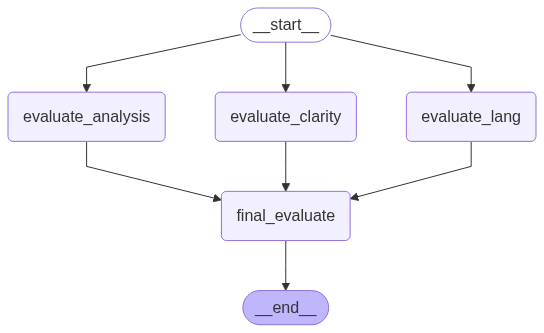

In [53]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())